#Importing Libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

#Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Training Image PreProcessing

In [3]:
training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_Vegetables_Detection_project/train',
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = None,
    color_mode ='rgb',
    batch_size = 32,
    image_size = (64,64),
    shuffle = True,
    seed = None,
    validation_split = None,
    subset = None,
    interpolation = 'bilinear',
    follow_links = False,
    crop_to_aspect_ratio = False
)

Found 3125 files belonging to 36 classes.


#Validation Image PreProcessing

In [4]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_Vegetables_Detection_project/validation',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 358 files belonging to 36 classes.


In [5]:
import json
labels = training_set.class_names   # <-- this works ONLY here
with open("labels.json", "w") as f:
    json.dump(labels, f)

In [6]:
# Normalize pixel values [0,255] -> [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
validation_set = validation_set.map(lambda x, y: (normalization_layer(x), y))


#Convulation Model

In [7]:
cnn = tf.keras.models.Sequential()

#Building Convulation Layer

In [8]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [10]:
cnn.add(tf.keras.layers.Flatten())

In [11]:
cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))

In [12]:
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))

In [13]:
cnn.add(tf.keras.layers.Dropout(0.5)) #We are Droping Some neuron to avoid Overfitting

#Output Layer

In [14]:
cnn.add(tf.keras.layers.Dense(units=36, activation='softmax'))

#Compiling Phase

In [15]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,538,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,744,452 (21.91 MB)

 Trainable params: 5,744,452 (21.91 MB)

 Non-trainable params: 0 (0.00 B)

#Training Phase

In [17]:
training_history = cnn.fit(x=training_set, validation_data=validation_set, epochs=32)

Epoch 1/32
98/98 ━━━━━━━━━━━━━━━━━━━━ 639s 6s/step - accuracy: 0.0441 - loss: 3.5454 - val_accuracy: 0.1564 - val_loss: 3.1440
Epoch 2/32
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.0996 - loss: 3.1866 - val_accuracy: 0.2011 - val_loss: 2.5897
Epoch 3/32
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1538 - loss: 2.8583 - val_accuracy: 0.3212 - val_loss: 2.1954
Epoch 4/32
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.2234 - loss: 2.5681 - val_accuracy: 0.4832 - val_loss: 1.7929
Epoch 5/32
98/98 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.3030 - loss: 2.2881 - val_accuracy: 0.5894 - val_loss: 1.4688
Epoch 6/32
98/98 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.3570 - loss: 2.0613 - val_accuracy: 0.6257 - val_loss: 1.2154
Epoch 7/32
98/98 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.4271 - loss: 1.8282 - val_accuracy: 0.6788 - val_loss: 1.0063
Epoch 8/32
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5067 - loss: 1.6077 - val_accuracy: 0.8128 - v

#Saving Model

In [22]:
cnn.save('trained_model.h5')

In [23]:
training_history.history #Return Dictionary of Hsitory

{'accuracy': [0.05663999915122986,
  0.1120000034570694,
  0.1849599927663803,
  0.24447999894618988,
  0.3190400004386902,
  0.3654400110244751,
  0.45184001326560974,
  0.551360011100769,
  0.639680027961731,
  0.7123200297355652,
  0.8019199967384338,
  0.8352000117301941,
  0.8796799778938293,
  0.8998399972915649,
  0.9251199960708618,
  0.955839991569519,
  0.944320023059845,
  0.9500799775123596,
  0.958079993724823,
  0.9635199904441833,
  0.9670400023460388,
  0.9715200066566467,
  0.9772800207138062,
  0.9785599708557129,
  0.9721599817276001,
  0.9820799827575684,
  0.9638400077819824,
  0.9750400185585022,
  0.9692800045013428,
  0.9772800207138062,
  0.978879988193512,
  0.9728000164031982],
 'loss': [3.466752767562866,
  3.087926149368286,
  2.7486865520477295,
  2.492921829223633,
  2.2280495166778564,
  2.0173895359039307,
  1.7435325384140015,
  1.4663896560668945,
  1.145565390586853,
  0.8815209269523621,
  0.6380351781845093,
  0.5287579894065857,
  0.38899919390678

#Recording History in JSON

In [24]:
import json
with open('training_hist.json', 'w') as f:
    json.dump(training_history.history, f)

In [25]:
print(training_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


#Calculating Accuracy of Model Achieved on Validation set

In [26]:
print("Validation set Accuracy: {} %".format(training_history.history['val_accuracy'][-1]* 100))

Validation set Accuracy: 95.53072452545166 %


#Accuracy Vizualization

##Training Visualization

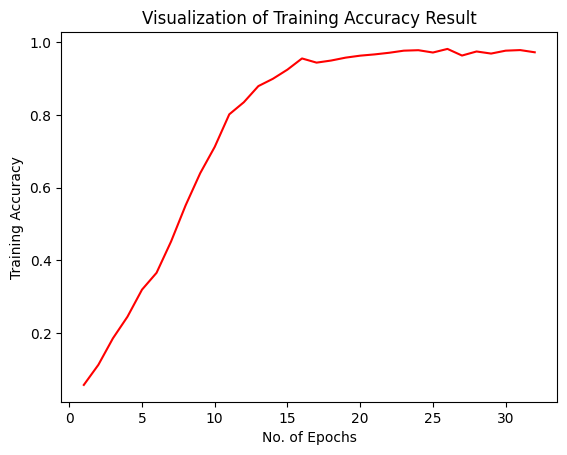

In [27]:
epochs = [i for i in range(1, 33)]
plt.plot(epochs, training_history.history['accuracy'], color='red')
plt.xlabel('No. of Epochs')
plt.ylabel('Training Accuracy')
plt.title('Visualization of Training Accuracy Result')
plt.show()

##Validation Accuracy

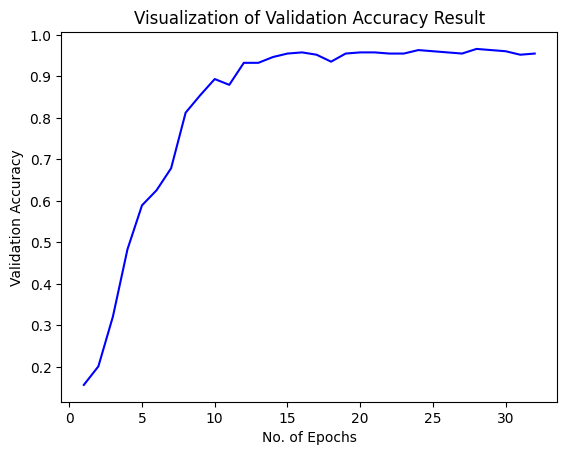

In [28]:
plt.plot(epochs, training_history.history['val_accuracy'], color='blue')
plt.xlabel('No. of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Visualization of Validation Accuracy Result')
plt.show()

##Keras Model Evaluate

In [29]:
training_loss, training_accuracy = cnn.evaluate(training_set)

98/98 ━━━━━━━━━━━━━━━━━━━━ 87s 888ms/step - accuracy: 0.9787 - loss: 0.0670


In [30]:
validation_loss, validation_accuracy = cnn.evaluate(validation_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 880ms/step - accuracy: 0.9519 - loss: 0.2115


In [31]:
test_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_Vegetables_Detection_project/test',
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = None,
    color_mode ='rgb',
    batch_size = 32,
    image_size = (64,64),
    shuffle = True,
    seed = None,
    validation_split = None,
    subset = None,
    interpolation = 'bilinear',
    follow_links = False,
    crop_to_aspect_ratio = False
)

Found 359 files belonging to 36 classes.


In [32]:
test_loss, test_accuracy = cnn.evaluate(test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step - accuracy: 0.8104 - loss: 224.8115
